# Laboratoire 3 - Machines à vecteur de support et réseaux neuronaux 
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LACAVE LACG14129705, ST-GERMAIN STGA15029404, BOPPE BOPA08069701  |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | AUTOMNE 2019                                            |
| Groupe                | 6                                                       |
| Numéro du laboratoire | 3                                                       |
| Professeur            | Prof.  Jose Dolz                                               |
| Chargé de laboratoire | Le Thanh Nguyen-Meidine                                                     |
| Date                  | 28/10/2019                                                    |

In [1]:
import numpy as np
import random
import math
import csv
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorboard
from keras.optimizers import SGD
import keras.backend as K

/home/adrien/anaconda3/envs/GPI770/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adrien/anaconda3/envs/GPI770/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adrien/anaconda3/envs/GPI770/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adrien/anaconda3/envs/GPI770/lib/python3

In [2]:
def read_csv(url):
    """
    Args:
        url (string): the url of the file
    Returns:
        df: the dataframe filled
    """
    df = pd.read_csv(url, header=None)
    df.head()
    return df

# Réseaux neuronaux avec TensorFlow 
Multi-Layer Perceptron

| Hyperparametre | valeur de base   |
|------|------|
|   Nombre de couches total | 4, y compris la couche d’entrée (input) et la couche de sortie (output) |
|   Nombre de perceptrons dans la couche cachée (hidden layer) | 100, 100, 2 |
|   Nombre d’itérations (epochs) | 60 |
|   Taux d’apprentissage (learningrate) | 0.0005 |
|   Batch size | 100 |

In [3]:
nb_layers = 4
nb_perceptron = [100,100,2]
nb_iteration = 60
learning_rate = 0.0005
batch_size = 100

## Version longue
1. Faire for loop pour Avec la librairie TensorFlow (avec l’API tf.keras) 
    1. Vous pouvez vous inspirer de la littérature, de recherches Internet, de la documentation de TensorFlow ou d’autres sources
    2. Ce modèle doit être original
    3. Il s’agit ici de construire un Multi-Layer Perceptron model.
    4. Faites attention aux nombres de perceptrons à l’entrée et à la sortie; la première valeur doit concorder avec le  nombre de caractéristiques [features] que votre vecteur en entrée comporte [son nombre de dimensions] alors que la deuxième doit concorder avec le nombre de classes que vous avez à la sortie.
        
2. Dans votre code source, vous devrez ajouter le code nécessaire à l’outil TensorBoard (TensorFlow) Cet outil vous permettra alors de suivre l’évolution des hyperparamètres, via un serveur Web local sur votre machine, et vous facilitera grandement  la tâche dans votre étude des réseaux neuronaux. Vous devez ajouter le code permettant de capturer les valeurs de la précision [accuracy] et la mesure de l’inconsistance entre la valeur prédite et la vraie valeur [loss].
3. Voir tableau Hyperparametre, vous devez sélectionner trois valeurs différentes et lancer l’apprentissage avec ces valeurs. **Vous aurez alors 12 modèles d’apprentissages différents**. Notez les résultats de la précision [accuracy] que vous avez obtenue au final. À la fin de vos manipulations, vous devriez avoir, par le biais de TensorBoard, des graphiques comme ci-dessous décrivant la précision [accuracy] et le loss. 
    1. *Aller voir enoncé pour exemples de graph*

## Version courte
1. Faire une for loop qui joue avec les hyperparametres
    1. Creer un reseau de neuronne avec les hyperparametres
    2. Utiliser TensorBoard pour capturer les valeurs de précision, de loss, le score F1 de chaque reseau
    3. Prenez en note le temps d’exécution de vos modèles autant en phase d’apprentissage qu’en phase de test.
    4. Afficher les graphiques

In [4]:
def OneHot(x):
    if x == 1:
        res = [1,0]
    elif x == 0:
        res = [0,0]
    return res

In [5]:
# read the csv and get the dataframe
df = read_csv("../galaxy_feature_vectors.csv")

# replace the output by a binairy vector 
new_labels = []
for i in df[75]:
    i = OneHot(i)
    new_labels.append(i)

# get the train and test sample
df = df.drop(0, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:, df.columns != 75], new_labels, test_size=0.2,stratify=df[75])

In [6]:
# Set labels as DataFrame
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

In [7]:
#Split the Train set into train and validate set
nx_train, nx_val, ny_train, ny_val = train_test_split(X_train, Y_train, test_size=0.2,stratify=Y_train)

In [8]:
#Custom metrics function to calculate the F1 score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def CreateMultiPerceptron(nb_layers,nb_perceptron,nb_iteration,learning_rate,nb_essai):
    #Create the model 
    model = Sequential()
    #First hidden layer with specified number of percpetrons 
    model.add(Dense(units=nb_perceptron, activation='sigmoid', input_dim = 74))
    
    for i in range(nb_layers-1):
        #Next hidden layers with specified number of percpetrons 
        model.add(Dense(units=nb_perceptron, activation='sigmoid'))
    
    #Last layer, the activation layer with 2 outputs
    model.add(Dense(units = 2, activation='sigmoid'))
    
    #Compile the model
    sgd = SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy',f1])
    
    #3. Entraîner 
    log_dir  = './logs/'+str(nb_essai)+'/nn_64'
    # On va utiliser Tensorboard pour visualizer le progrès de l'entraînement
    tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(nx_train, ny_train, validation_data=(nx_val, ny_val),
              epochs=nb_iteration, batch_size=100, callbacks=[tb_callback])
    
    # Plot training & validation accuracy values
    accuracy = pd.DataFrame(history.history['accuracy'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print("Accuracy")
    print(accuracy.head(nb_iteration))
    
    # Plot training & validation loss values
    f1score = pd.DataFrame(history.history['f1'])
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('Model F1 score')
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print("F1 score")
    print(f1score.head(nb_iteration))
    
    
    #4 Evaluer le modèle
    score = model.evaluate(X_test, Y_test)
    print("---TEST---")
    print(score)

La création et l'évaluation du modèle se fait à l'aide d'une fonction à laquelle on peut passer les différents paramètres qui varient.

Les paramètres sont passés dans l'ordre suivant : 
- nombre de couches cachées (donc sans compter la couche d'entrée et la couche de sortie)
- nombre de perceptrons sur les couches cachées
- nombre d'itération pendant l'entrainement
- le taux d'apprentissage
- le numéro de l'essai pour enregistrer les graphs générés dans des dossiers séparés

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 36us/step - loss: 0.4446 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4375 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.4317 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4262 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/60
10820/10820 [==============================] - 0s 22us/step - loss: 0.4217 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4173 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 4/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.4136 - accuracy: 0.7533 - f1: 0.4028 - val_loss: 0.4101 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.4071 - accuracy: 0

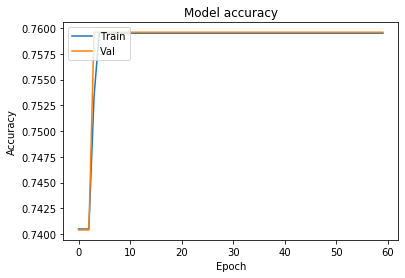

Accuracy
           0
0   0.740481
1   0.740481
2   0.740481
3   0.753327
4   0.759519
5   0.759519
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


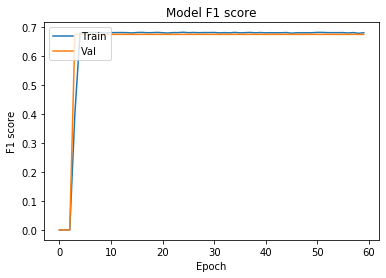

F1 score
           0
0   0.000000
1   0.000000
2   0.000000
3   0.402822
4   0.679761
5   0.680894
6   0.682433
7   0.682117
8   0.682260
9   0.680604
10  0.681900
11  0.681961
12  0.682342
13  0.681923
14  0.680939
15  0.682349
16  0.682853
17  0.681673
18  0.681897
19  0.682720
20  0.681618
21  0.680577
22  0.682058
23  0.682000
24  0.683314
25  0.681726
26  0.682441
27  0.681677
28  0.682200
29  0.682105
30  0.682481
31  0.681221
32  0.681939
33  0.681217
34  0.682710
35  0.681237
36  0.681849
37  0.682553
38  0.681211
39  0.682326
40  0.681245
41  0.681715
42  0.681502
43  0.681611
44  0.682281
45  0.680058
46  0.681445
47  0.681667
48  0.681575
49  0.681697
50  0.682755
51  0.682726
52  0.681976
53  0.681887
54  0.681903
55  0.682103
56  0.680757
57  0.682061
58  0.679631
59  0.681730
3382/3382 [==============================] - 0s 18us/step
---TEST---
[0.35488251255222636, 0.7594618797302246, 0.6785072684288025]


In [10]:
K.clear_session()
# Avec les paramètres par défaut donnés dans l'ennoncé
CreateMultiPerceptron(2,100,60,0.0005,1) 

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 44us/step - loss: 0.7496 - accuracy: 0.4078 - f1: 0.0000e+00 - val_loss: 0.6884 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 28us/step - loss: 0.6436 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.6033 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/60
10820/10820 [==============================] - 0s 24us/step - loss: 0.5733 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5461 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 4/60
10820/10820 [==============================] - 0s 34us/step - loss: 0.5255 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5067 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 5/60
10820/10820 [==============================] - 0s 24us/step - loss: 0.4921 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4786 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 6/60
10820/10820 [==

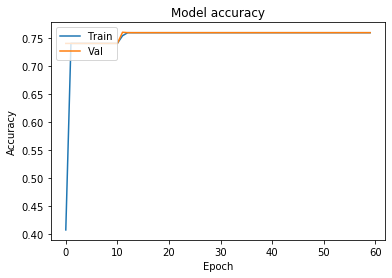

Accuracy
           0
0   0.407763
1   0.740481
2   0.740481
3   0.740481
4   0.740481
5   0.740481
6   0.740481
7   0.740481
8   0.740481
9   0.740481
10  0.740481
11  0.754113
12  0.759566
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


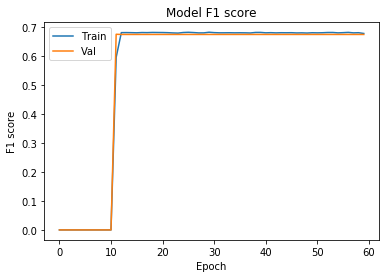

F1 score
           0
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.000000
5   0.000000
6   0.000000
7   0.000000
8   0.000000
9   0.000000
10  0.000000
11  0.596897
12  0.682178
13  0.682366
14  0.682077
15  0.681609
16  0.682509
17  0.682198
18  0.682872
19  0.682634
20  0.682533
21  0.682028
22  0.681189
23  0.680578
24  0.682632
25  0.683345
26  0.682444
27  0.681242
28  0.681349
29  0.683565
30  0.682201
31  0.681546
32  0.681617
33  0.681816
34  0.681499
35  0.681699
36  0.681484
37  0.681011
38  0.682809
39  0.682942
40  0.681532
41  0.682044
42  0.681336
43  0.681896
44  0.681706
45  0.681944
46  0.681083
47  0.681465
48  0.680782
49  0.681819
50  0.681439
51  0.681835
52  0.682641
53  0.682730
54  0.681371
55  0.682112
56  0.683054
57  0.681392
58  0.681931
59  0.679274
3382/3382 [==============================] - 0s 34us/step
---TEST---
[0.35631561677601126, 0.7594618797302246, 0.6785072684288025]


In [11]:
K.clear_session()
# Avec 3 couches cachés
CreateMultiPerceptron(3,100,60,0.0005,2)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 1s 67us/step - loss: 0.7180 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.6644 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 44us/step - loss: 0.6242 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5878 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/60
10820/10820 [==============================] - 0s 44us/step - loss: 0.5602 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5350 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 4/60
10820/10820 [==============================] - 1s 47us/step - loss: 0.5156 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4980 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 5/60
10820/10820 [==============================] - 0s 45us/step - loss: 0.4841 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4712 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 6/60
10820/10820 [==

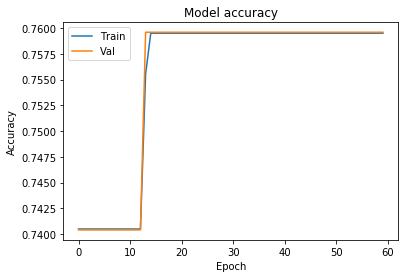

Accuracy
           0
0   0.740481
1   0.740481
2   0.740481
3   0.740481
4   0.740481
5   0.740481
6   0.740481
7   0.740481
8   0.740481
9   0.740481
10  0.740481
11  0.740481
12  0.740481
13  0.755545
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


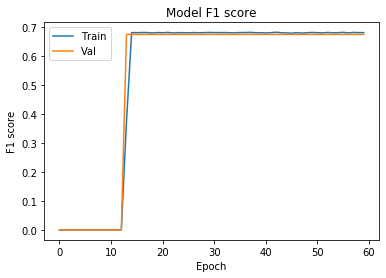

F1 score
           0
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.000000
5   0.000000
6   0.000000
7   0.000000
8   0.000000
9   0.000000
10  0.000000
11  0.000000
12  0.000000
13  0.373838
14  0.682300
15  0.681856
16  0.682404
17  0.682363
18  0.680704
19  0.682313
20  0.681580
21  0.682787
22  0.680905
23  0.681916
24  0.681820
25  0.681451
26  0.682213
27  0.681713
28  0.681926
29  0.682682
30  0.682287
31  0.682057
32  0.682228
33  0.681799
34  0.681208
35  0.682273
36  0.682386
37  0.683011
38  0.681774
39  0.681538
40  0.681082
41  0.681921
42  0.683376
43  0.681604
44  0.681178
45  0.680094
46  0.682054
47  0.680612
48  0.681646
49  0.682668
50  0.681758
51  0.681161
52  0.682601
53  0.681389
54  0.681749
55  0.683052
56  0.681082
57  0.682758
58  0.681969
59  0.682214
3382/3382 [==============================] - 0s 34us/step
---TEST---
[0.35617541140666875, 0.7594618797302246, 0.6785072684288025]


In [12]:
K.clear_session()
# Avec 10 couches cachés
CreateMultiPerceptron(10,100,60,0.0005,3)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 30us/step - loss: 0.7582 - accuracy: 0.2595 - f1: 0.4117 - val_loss: 0.7276 - val_accuracy: 0.2596 - val_f1: 0.4073
Epoch 2/60
10820/10820 [==============================] - 0s 18us/step - loss: 0.7016 - accuracy: 0.6116 - f1: 0.6029 - val_loss: 0.6764 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/60
10820/10820 [==============================] - 0s 17us/step - loss: 0.6551 - accuracy: 0.7595 - f1: 0.6823 - val_loss: 0.6344 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/60
10820/10820 [==============================] - 0s 15us/step - loss: 0.6169 - accuracy: 0.7595 - f1: 0.6806 - val_loss: 0.5997 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/60
10820/10820 [==============================] - 0s 16us/step - loss: 0.5852 - accuracy: 0.7595 - f1: 0.6814 - val_loss: 0.5710 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/60
10820/10820 [==============================] - 0s 16us/

Epoch 47/60
10820/10820 [==============================] - 0s 14us/step - loss: 0.3748 - accuracy: 0.7595 - f1: 0.6821 - val_loss: 0.3744 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 48/60
10820/10820 [==============================] - 0s 14us/step - loss: 0.3741 - accuracy: 0.7595 - f1: 0.6803 - val_loss: 0.3738 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 49/60
10820/10820 [==============================] - 0s 14us/step - loss: 0.3735 - accuracy: 0.7595 - f1: 0.6821 - val_loss: 0.3732 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 50/60
10820/10820 [==============================] - 0s 15us/step - loss: 0.3729 - accuracy: 0.7595 - f1: 0.6814 - val_loss: 0.3726 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 51/60
10820/10820 [==============================] - 0s 14us/step - loss: 0.3723 - accuracy: 0.7595 - f1: 0.6816 - val_loss: 0.3720 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 52/60
10820/10820 [==============================] - 0s 14us/step - loss: 0.3717 - accuracy: 0.7595 - f1

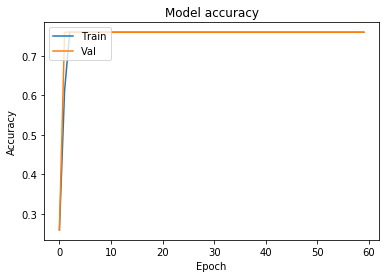

Accuracy
           0
0   0.259519
1   0.611645
2   0.759519
3   0.759519
4   0.759519
5   0.759519
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


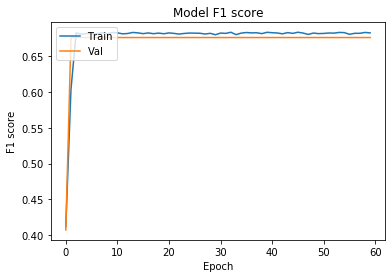

F1 score
           0
0   0.411694
1   0.602935
2   0.682346
3   0.680620
4   0.681447
5   0.681169
6   0.681160
7   0.682680
8   0.681193
9   0.682955
10  0.682494
11  0.681069
12  0.681534
13  0.683001
14  0.682386
15  0.681350
16  0.682328
17  0.681284
18  0.682093
19  0.681197
20  0.682349
21  0.681658
22  0.680772
23  0.681644
24  0.682163
25  0.682026
26  0.681878
27  0.680794
28  0.681778
29  0.679824
30  0.682153
31  0.681683
32  0.683259
33  0.679982
34  0.682099
35  0.682883
36  0.682406
37  0.682589
38  0.681361
39  0.683206
40  0.682648
41  0.682251
42  0.681099
43  0.682773
44  0.681728
45  0.683295
46  0.682133
47  0.680271
48  0.682145
49  0.681367
50  0.681646
51  0.682208
52  0.682082
53  0.683045
54  0.682762
55  0.680427
56  0.681816
57  0.681812
58  0.682994
59  0.682401
3382/3382 [==============================] - 0s 13us/step
---TEST---
[0.36780000062541524, 0.7594618797302246, 0.6785072684288025]


In [13]:
K.clear_session()
# Avec 50 perceptrons
CreateMultiPerceptron(2,50,60,0.0005,4)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 40us/step - loss: 0.5666 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5164 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 32us/step - loss: 0.4860 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4608 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/60
10820/10820 [==============================] - 0s 28us/step - loss: 0.4449 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4308 - val_accuracy: 0.7402 - val_f1: 0.0000e+00
Epoch 4/60
10820/10820 [==============================] - 0s 28us/step - loss: 0.4209 - accuracy: 0.7404 - f1: 3.3361e-04 - val_loss: 0.4122 - val_accuracy: 0.7400 - val_f1: 0.0000e+00
Epoch 5/60
10820/10820 [==============================] - 0s 29us/step - loss: 0.4059 - accuracy: 0.7403 - f1: 7.2801e-04 - val_loss: 0.4002 - val_accuracy: 0.7398 - val_f1: 0.0000e+00
Epoch 6/60
10820/10820 [==

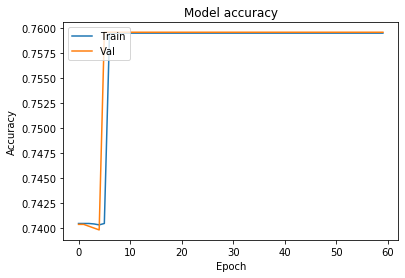

Accuracy
           0
0   0.740481
1   0.740481
2   0.740481
3   0.740434
4   0.740342
5   0.740481
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


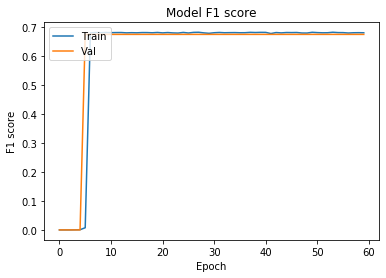

F1 score
           0
0   0.000000
1   0.000000
2   0.000000
3   0.000334
4   0.000728
5   0.007519
6   0.680892
7   0.682229
8   0.681622
9   0.682401
10  0.681912
11  0.682180
12  0.682325
13  0.681204
14  0.681784
15  0.681360
16  0.682209
17  0.682154
18  0.681471
19  0.682578
20  0.681128
21  0.682258
22  0.681047
23  0.680473
24  0.682702
25  0.680718
26  0.682853
27  0.683223
28  0.681131
29  0.679645
30  0.681630
31  0.682540
32  0.681606
33  0.681941
34  0.682095
35  0.681595
36  0.681744
37  0.682943
38  0.682371
39  0.682926
40  0.682807
41  0.678887
42  0.682273
43  0.681124
44  0.682347
45  0.682144
46  0.682440
47  0.680706
48  0.680556
49  0.683187
50  0.682048
51  0.681426
52  0.681604
53  0.683334
54  0.682101
55  0.681992
56  0.680642
57  0.681577
58  0.681820
59  0.681532
3382/3382 [==============================] - 0s 25us/step
---TEST---
[0.35087002698378333, 0.7594618797302246, 0.6785072684288025]


In [14]:
K.clear_session()
# Avec 200 perceptrons
CreateMultiPerceptron(2,200,60,0.0005,5)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 1s 95us/step - loss: 0.7955 - accuracy: 0.4823 - f1: 0.5343 - val_loss: 0.5361 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 2/60
10820/10820 [==============================] - 1s 70us/step - loss: 0.4694 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.4275 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/60
10820/10820 [==============================] - 1s 71us/step - loss: 0.4094 - accuracy: 0.7595 - f1: 0.6825 - val_loss: 0.3957 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/60
10820/10820 [==============================] - 1s 71us/step - loss: 0.3880 - accuracy: 0.7595 - f1: 0.6810 - val_loss: 0.3814 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/60
10820/10820 [==============================] - 1s 71us/step - loss: 0.3772 - accuracy: 0.7595 - f1: 0.6811 - val_loss: 0.3734 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/60
10820/10820 [==============================] - 1s 70us/

Epoch 47/60
10820/10820 [==============================] - 1s 79us/step - loss: 0.3487 - accuracy: 0.7595 - f1: 0.6793 - val_loss: 0.3487 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 48/60
10820/10820 [==============================] - 1s 69us/step - loss: 0.3487 - accuracy: 0.7595 - f1: 0.6827 - val_loss: 0.3486 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 49/60
10820/10820 [==============================] - 1s 90us/step - loss: 0.3486 - accuracy: 0.7595 - f1: 0.6829 - val_loss: 0.3486 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 50/60
10820/10820 [==============================] - 1s 68us/step - loss: 0.3486 - accuracy: 0.7595 - f1: 0.6816 - val_loss: 0.3485 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 51/60
10820/10820 [==============================] - 1s 59us/step - loss: 0.3485 - accuracy: 0.7595 - f1: 0.6827 - val_loss: 0.3485 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 52/60
10820/10820 [==============================] - 1s 57us/step - loss: 0.3484 - accuracy: 0.7595 - f1

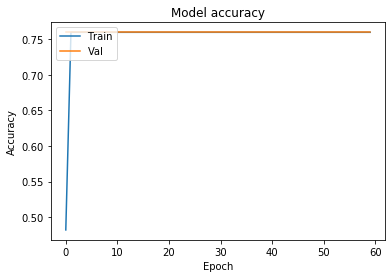

Accuracy
           0
0   0.482255
1   0.759519
2   0.759519
3   0.759519
4   0.759519
5   0.759519
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


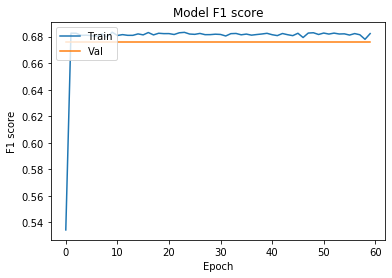

F1 score
           0
0   0.534264
1   0.682610
2   0.682535
3   0.680964
4   0.681057
5   0.680797
6   0.680228
7   0.681937
8   0.679645
9   0.683294
10  0.680845
11  0.681502
12  0.680968
13  0.680961
14  0.682046
15  0.681312
16  0.683070
17  0.681284
18  0.682532
19  0.682250
20  0.682267
21  0.681589
22  0.682886
23  0.683213
24  0.681944
25  0.681711
26  0.682400
27  0.681466
28  0.681494
29  0.681823
30  0.681629
31  0.680478
32  0.682233
33  0.682377
34  0.681363
35  0.681906
36  0.681101
37  0.681567
38  0.681971
39  0.682488
40  0.681434
41  0.680763
42  0.682330
43  0.681443
44  0.680736
45  0.682521
46  0.679312
47  0.682682
48  0.682912
49  0.681612
50  0.682685
51  0.681916
52  0.682636
53  0.681967
54  0.682093
55  0.681165
56  0.682289
57  0.681408
58  0.677968
59  0.682270
3382/3382 [==============================] - 0s 41us/step
---TEST---
[0.34811515955442796, 0.7594618797302246, 0.6785072684288025]


In [15]:
K.clear_session()
# Avec 500 perceptrons
CreateMultiPerceptron(2,500,60,0.0005,6)

Train on 10820 samples, validate on 2706 samples
Epoch 1/10
10820/10820 [==============================] - 0s 37us/step - loss: 0.8605 - accuracy: 0.2405 - f1: 0.0000e+00 - val_loss: 0.7731 - val_accuracy: 0.2404 - val_f1: 0.0000e+00
Epoch 2/10
10820/10820 [==============================] - 0s 24us/step - loss: 0.7101 - accuracy: 0.4725 - f1: 0.0000e+00 - val_loss: 0.6540 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/10
10820/10820 [==============================] - 0s 23us/step - loss: 0.6136 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5774 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 4/10
10820/10820 [==============================] - 0s 22us/step - loss: 0.5509 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5269 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 5/10
10820/10820 [==============================] - 0s 34us/step - loss: 0.5088 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.4922 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 6/10
10820/10820 [==

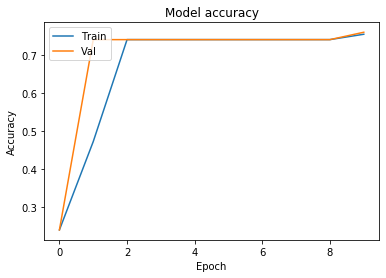

Accuracy
          0
0  0.240481
1  0.472458
2  0.740481
3  0.740481
4  0.740481
5  0.740481
6  0.740481
7  0.740481
8  0.740481
9  0.754529


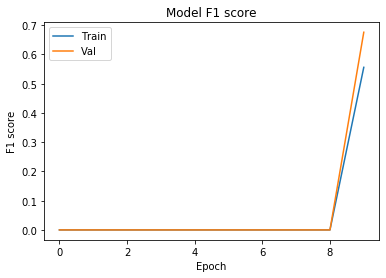

F1 score
          0
0  0.000000
1  0.000000
2  0.000000
3  0.000000
4  0.000000
5  0.000000
6  0.000000
7  0.000000
8  0.000000
9  0.556084
3382/3382 [==============================] - 0s 27us/step
---TEST---
[0.4160582053104425, 0.7594618797302246, 0.6785072684288025]


In [16]:
K.clear_session()
# Avec 10 itérations
CreateMultiPerceptron(2,100,10,0.0005,7)

Train on 10820 samples, validate on 2706 samples
Epoch 1/120
10820/10820 [==============================] - 0s 35us/step - loss: 0.6870 - accuracy: 0.7595 - f1: 0.6825 - val_loss: 0.6388 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 2/120
10820/10820 [==============================] - 0s 24us/step - loss: 0.6031 - accuracy: 0.7595 - f1: 0.6825 - val_loss: 0.5706 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/120
10820/10820 [==============================] - 0s 25us/step - loss: 0.5461 - accuracy: 0.7595 - f1: 0.6818 - val_loss: 0.5236 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/120
10820/10820 [==============================] - 0s 28us/step - loss: 0.5064 - accuracy: 0.7595 - f1: 0.6829 - val_loss: 0.4904 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/120
10820/10820 [==============================] - 0s 33us/step - loss: 0.4780 - accuracy: 0.7595 - f1: 0.6813 - val_loss: 0.4663 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/120
10820/10820 [==============================] - 0s

Epoch 92/120
10820/10820 [==============================] - 0s 19us/step - loss: 0.3524 - accuracy: 0.7596 - f1: 0.6821 - val_loss: 0.3524 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 93/120
10820/10820 [==============================] - 0s 21us/step - loss: 0.3524 - accuracy: 0.7596 - f1: 0.6824 - val_loss: 0.3523 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 94/120
10820/10820 [==============================] - 0s 20us/step - loss: 0.3523 - accuracy: 0.7596 - f1: 0.6827 - val_loss: 0.3522 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 95/120
10820/10820 [==============================] - 0s 21us/step - loss: 0.3522 - accuracy: 0.7596 - f1: 0.6828 - val_loss: 0.3522 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 96/120
10820/10820 [==============================] - 0s 20us/step - loss: 0.3522 - accuracy: 0.7596 - f1: 0.6813 - val_loss: 0.3521 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 97/120
10820/10820 [==============================] - 0s 20us/step - loss: 0.3521 - accuracy: 0.759

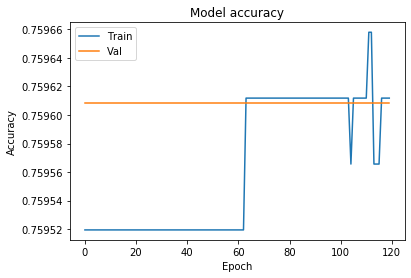

Accuracy
            0
0    0.759519
1    0.759519
2    0.759519
3    0.759519
4    0.759519
..        ...
115  0.759566
116  0.759612
117  0.759612
118  0.759612
119  0.759612

[120 rows x 1 columns]


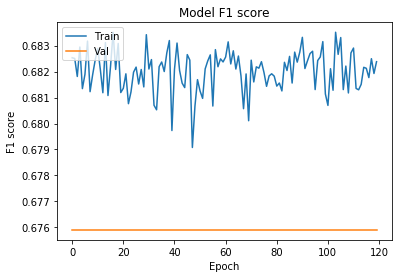

F1 score
            0
0    0.682533
1    0.682506
2    0.681813
3    0.682947
4    0.681345
..        ...
115  0.682128
116  0.681770
117  0.682498
118  0.681928
119  0.682382

[120 rows x 1 columns]
3382/3382 [==============================] - 0s 20us/step
---TEST---
[0.35089898682218695, 0.7593140006065369, 0.6782156229019165]


In [17]:
K.clear_session()
# Avec 120 itérations
CreateMultiPerceptron(2,100,120,0.0005,8)

Train on 10820 samples, validate on 2706 samples
Epoch 1/500
10820/10820 [==============================] - 0s 35us/step - loss: 0.8215 - accuracy: 0.2595 - f1: 0.4107 - val_loss: 0.7409 - val_accuracy: 0.2596 - val_f1: 0.4073
Epoch 2/500
10820/10820 [==============================] - 0s 22us/step - loss: 0.6833 - accuracy: 0.6209 - f1: 0.6080 - val_loss: 0.6321 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.5954 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.5624 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.5381 - accuracy: 0.7595 - f1: 0.6818 - val_loss: 0.5161 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/500
10820/10820 [==============================] - 0s 21us/step - loss: 0.4995 - accuracy: 0.7595 - f1: 0.6829 - val_loss: 0.4842 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/500
10820/10820 [==============================] - 0s

Epoch 92/500
10820/10820 [==============================] - 0s 28us/step - loss: 0.3523 - accuracy: 0.7595 - f1: 0.6827 - val_loss: 0.3523 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 93/500
10820/10820 [==============================] - 0s 24us/step - loss: 0.3523 - accuracy: 0.7595 - f1: 0.6811 - val_loss: 0.3522 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 94/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3522 - accuracy: 0.7595 - f1: 0.6802 - val_loss: 0.3522 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 95/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3521 - accuracy: 0.7595 - f1: 0.6804 - val_loss: 0.3521 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 96/500
10820/10820 [==============================] - 0s 21us/step - loss: 0.3521 - accuracy: 0.7595 - f1: 0.6806 - val_loss: 0.3520 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 97/500
10820/10820 [==============================] - 0s 21us/step - loss: 0.3520 - accuracy: 0.759

10820/10820 [==============================] - 0s 19us/step - loss: 0.3492 - accuracy: 0.7595 - f1: 0.6813 - val_loss: 0.3492 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 183/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3492 - accuracy: 0.7595 - f1: 0.6815 - val_loss: 0.3492 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 184/500
10820/10820 [==============================] - 0s 32us/step - loss: 0.3492 - accuracy: 0.7595 - f1: 0.6818 - val_loss: 0.3491 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 185/500
10820/10820 [==============================] - 0s 22us/step - loss: 0.3491 - accuracy: 0.7595 - f1: 0.6822 - val_loss: 0.3491 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 186/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3491 - accuracy: 0.7595 - f1: 0.6808 - val_loss: 0.3491 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 187/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3491 - accuracy: 0.7595 - f1: 

10820/10820 [==============================] - 0s 20us/step - loss: 0.3482 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.3482 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 273/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3482 - accuracy: 0.7595 - f1: 0.6817 - val_loss: 0.3481 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 274/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3482 - accuracy: 0.7595 - f1: 0.6820 - val_loss: 0.3481 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 275/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3482 - accuracy: 0.7595 - f1: 0.6821 - val_loss: 0.3481 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 276/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3481 - accuracy: 0.7595 - f1: 0.6829 - val_loss: 0.3481 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 277/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3481 - accuracy: 0.7595 - f1: 

10820/10820 [==============================] - 0s 19us/step - loss: 0.3477 - accuracy: 0.7595 - f1: 0.6830 - val_loss: 0.3477 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 363/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3477 - accuracy: 0.7595 - f1: 0.6821 - val_loss: 0.3476 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 364/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3477 - accuracy: 0.7595 - f1: 0.6810 - val_loss: 0.3476 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 365/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3477 - accuracy: 0.7595 - f1: 0.6833 - val_loss: 0.3476 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 366/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3477 - accuracy: 0.7595 - f1: 0.6822 - val_loss: 0.3476 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 367/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3476 - accuracy: 0.7595 - f1: 

10820/10820 [==============================] - 0s 19us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 0.6820 - val_loss: 0.3474 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 453/500
10820/10820 [==============================] - 0s 20us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 0.6819 - val_loss: 0.3474 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 454/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 0.6810 - val_loss: 0.3473 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 455/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 0.6811 - val_loss: 0.3473 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 456/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 0.6804 - val_loss: 0.3473 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 457/500
10820/10820 [==============================] - 0s 19us/step - loss: 0.3474 - accuracy: 0.7595 - f1: 

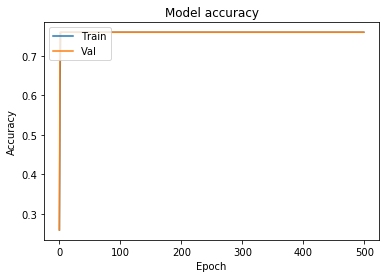

Accuracy
            0
0    0.259519
1    0.620887
2    0.759519
3    0.759519
4    0.759519
..        ...
495  0.759519
496  0.759519
497  0.759519
498  0.759519
499  0.759519

[500 rows x 1 columns]


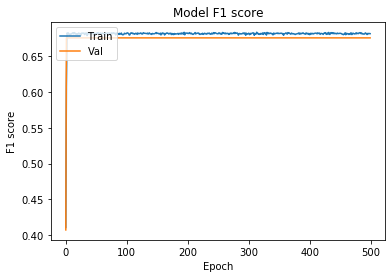

F1 score
            0
0    0.410746
1    0.608042
2    0.682575
3    0.681764
4    0.682938
..        ...
495  0.682120
496  0.681623
497  0.682172
498  0.681851
499  0.681783

[500 rows x 1 columns]
3382/3382 [==============================] - 0s 16us/step
---TEST---
[0.3472565696092839, 0.7594618797302246, 0.6785072684288025]


In [18]:
K.clear_session()
# Avec 500 itérations
CreateMultiPerceptron(2,100,500,0.0005,9)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 31us/step - loss: 0.6173 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.6102 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 2/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.6038 - accuracy: 0.7595 - f1: 0.6831 - val_loss: 0.5973 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/60
10820/10820 [==============================] - 0s 24us/step - loss: 0.5913 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.5852 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.5796 - accuracy: 0.7595 - f1: 0.6825 - val_loss: 0.5740 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.5688 - accuracy: 0.7595 - f1: 0.6824 - val_loss: 0.5635 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/60
10820/10820 [==============================] - 0s 21us/

Epoch 47/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.4090 - accuracy: 0.7595 - f1: 0.6817 - val_loss: 0.4084 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 48/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.4079 - accuracy: 0.7595 - f1: 0.6826 - val_loss: 0.4073 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 49/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.4068 - accuracy: 0.7595 - f1: 0.6824 - val_loss: 0.4062 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 50/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.4057 - accuracy: 0.7595 - f1: 0.6811 - val_loss: 0.4051 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 51/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.4046 - accuracy: 0.7595 - f1: 0.6824 - val_loss: 0.4041 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 52/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.4036 - accuracy: 0.7595 - f1

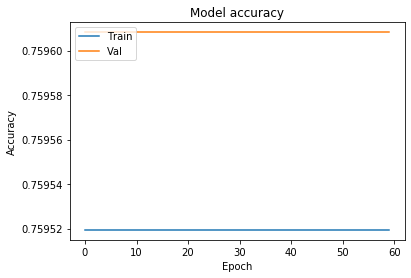

Accuracy
           0
0   0.759519
1   0.759519
2   0.759519
3   0.759519
4   0.759519
5   0.759519
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


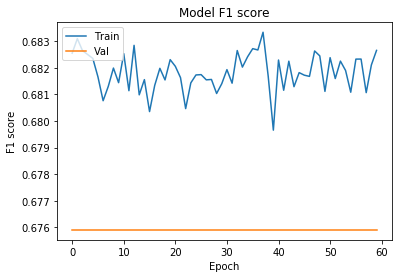

F1 score
           0
0   0.682550
1   0.683097
2   0.682647
3   0.682501
4   0.682355
5   0.681658
6   0.680762
7   0.681302
8   0.681991
9   0.681441
10  0.682533
11  0.681139
12  0.682846
13  0.680984
14  0.681556
15  0.680354
16  0.681339
17  0.681981
18  0.681545
19  0.682308
20  0.682056
21  0.681631
22  0.680466
23  0.681434
24  0.681732
25  0.681744
26  0.681548
27  0.681562
28  0.681034
29  0.681403
30  0.681932
31  0.681422
32  0.682650
33  0.682027
34  0.682414
35  0.682722
36  0.682672
37  0.683339
38  0.681685
39  0.679655
40  0.682293
41  0.681156
42  0.682250
43  0.681290
44  0.681820
45  0.681723
46  0.681678
47  0.682635
48  0.682449
49  0.681114
50  0.682383
51  0.681597
52  0.682252
53  0.681899
54  0.681082
55  0.682328
56  0.682330
57  0.681067
58  0.682108
59  0.682656
3382/3382 [==============================] - 0s 21us/step
---TEST---
[0.3962960677306233, 0.7594618797302246, 0.6785072684288025]


In [19]:
K.clear_session()
# Avec 0.0001 comme taux d'apprentissage
CreateMultiPerceptron(2,100,60,0.0001,10)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 36us/step - loss: 0.4667 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.3982 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 24us/step - loss: 0.3828 - accuracy: 0.7506 - f1: 0.3875 - val_loss: 0.3724 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 3/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.3677 - accuracy: 0.7595 - f1: 0.6830 - val_loss: 0.3639 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 4/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.3615 - accuracy: 0.7595 - f1: 0.6811 - val_loss: 0.3595 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 5/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.3581 - accuracy: 0.7595 - f1: 0.6823 - val_loss: 0.3568 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 6/60
10820/10820 [==============================] - 

Epoch 47/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.3473 - accuracy: 0.7595 - f1: 0.6814 - val_loss: 0.3473 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 48/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.3473 - accuracy: 0.7595 - f1: 0.6816 - val_loss: 0.3472 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 49/60
10820/10820 [==============================] - 0s 37us/step - loss: 0.3473 - accuracy: 0.7595 - f1: 0.6815 - val_loss: 0.3472 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 50/60
10820/10820 [==============================] - 0s 24us/step - loss: 0.3472 - accuracy: 0.7595 - f1: 0.6823 - val_loss: 0.3472 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 51/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.3472 - accuracy: 0.7595 - f1: 0.6814 - val_loss: 0.3472 - val_accuracy: 0.7596 - val_f1: 0.6759
Epoch 52/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.3472 - accuracy: 0.7595 - f1

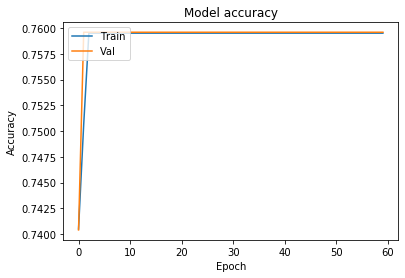

Accuracy
           0
0   0.740481
1   0.750647
2   0.759519
3   0.759519
4   0.759519
5   0.759519
6   0.759519
7   0.759519
8   0.759519
9   0.759519
10  0.759519
11  0.759519
12  0.759519
13  0.759519
14  0.759519
15  0.759519
16  0.759519
17  0.759519
18  0.759519
19  0.759519
20  0.759519
21  0.759519
22  0.759519
23  0.759519
24  0.759519
25  0.759519
26  0.759519
27  0.759519
28  0.759519
29  0.759519
30  0.759519
31  0.759519
32  0.759519
33  0.759519
34  0.759519
35  0.759519
36  0.759519
37  0.759519
38  0.759519
39  0.759519
40  0.759519
41  0.759519
42  0.759519
43  0.759519
44  0.759519
45  0.759519
46  0.759519
47  0.759519
48  0.759519
49  0.759519
50  0.759519
51  0.759519
52  0.759519
53  0.759519
54  0.759519
55  0.759519
56  0.759519
57  0.759519
58  0.759519
59  0.759519


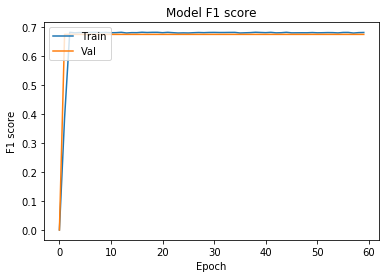

F1 score
           0
0   0.000000
1   0.387540
2   0.683020
3   0.681118
4   0.682298
5   0.681763
6   0.682531
7   0.682756
8   0.681995
9   0.682591
10  0.681620
11  0.681883
12  0.683167
13  0.680684
14  0.681961
15  0.681796
16  0.683342
17  0.682416
18  0.683017
19  0.683049
20  0.681736
21  0.683036
22  0.681794
23  0.680639
24  0.681160
25  0.680758
26  0.681721
27  0.682420
28  0.681876
29  0.682549
30  0.682721
31  0.682380
32  0.682432
33  0.682676
34  0.682833
35  0.680789
36  0.681412
37  0.682023
38  0.683234
39  0.682511
40  0.681879
41  0.682956
42  0.681210
43  0.681672
44  0.683123
45  0.681259
46  0.681394
47  0.681563
48  0.681451
49  0.682270
50  0.681377
51  0.681676
52  0.682131
53  0.681974
54  0.680998
55  0.682612
56  0.682681
57  0.680530
58  0.682031
59  0.682521
3382/3382 [==============================] - 0s 19us/step
---TEST---
[0.34703600293852604, 0.7594618797302246, 0.6785072684288025]


In [20]:
K.clear_session()
# Avec 0.005 comme taux d'apprentissage
CreateMultiPerceptron(2,100,60,0.005,11)

Train on 10820 samples, validate on 2706 samples
Epoch 1/60
10820/10820 [==============================] - 0s 35us/step - loss: 0.5629 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5624 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 2/60
10820/10820 [==============================] - 0s 26us/step - loss: 0.5618 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5613 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 3/60
10820/10820 [==============================] - 0s 22us/step - loss: 0.5607 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5602 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 4/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.5596 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5591 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 5/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.5586 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5580 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 6/60
10820/10820 [==

Epoch 45/60
10820/10820 [==============================] - 0s 21us/step - loss: 0.5215 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5212 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 46/60
10820/10820 [==============================] - 0s 20us/step - loss: 0.5208 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5204 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 47/60
10820/10820 [==============================] - 0s 19us/step - loss: 0.5200 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5196 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 48/60
10820/10820 [==============================] - 0s 26us/step - loss: 0.5192 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5188 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 49/60
10820/10820 [==============================] - 0s 34us/step - loss: 0.5184 - accuracy: 0.7405 - f1: 0.0000e+00 - val_loss: 0.5180 - val_accuracy: 0.7404 - val_f1: 0.0000e+00
Epoch 50/60
10820/10820 [==============================] - 0s 29us/ste

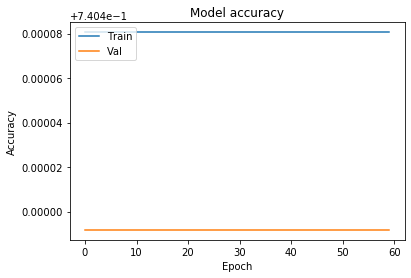

Accuracy
           0
0   0.740481
1   0.740481
2   0.740481
3   0.740481
4   0.740481
5   0.740481
6   0.740481
7   0.740481
8   0.740481
9   0.740481
10  0.740481
11  0.740481
12  0.740481
13  0.740481
14  0.740481
15  0.740481
16  0.740481
17  0.740481
18  0.740481
19  0.740481
20  0.740481
21  0.740481
22  0.740481
23  0.740481
24  0.740481
25  0.740481
26  0.740481
27  0.740481
28  0.740481
29  0.740481
30  0.740481
31  0.740481
32  0.740481
33  0.740481
34  0.740481
35  0.740481
36  0.740481
37  0.740481
38  0.740481
39  0.740481
40  0.740481
41  0.740481
42  0.740481
43  0.740481
44  0.740481
45  0.740481
46  0.740481
47  0.740481
48  0.740481
49  0.740481
50  0.740481
51  0.740481
52  0.740481
53  0.740481
54  0.740481
55  0.740481
56  0.740481
57  0.740481
58  0.740481
59  0.740481


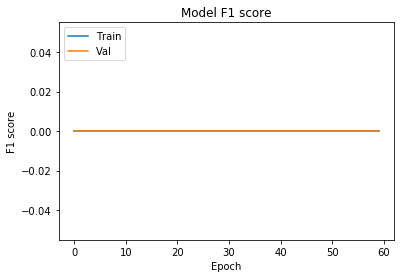

F1 score
      0
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0
5   0.0
6   0.0
7   0.0
8   0.0
9   0.0
10  0.0
11  0.0
12  0.0
13  0.0
14  0.0
15  0.0
16  0.0
17  0.0
18  0.0
19  0.0
20  0.0
21  0.0
22  0.0
23  0.0
24  0.0
25  0.0
26  0.0
27  0.0
28  0.0
29  0.0
30  0.0
31  0.0
32  0.0
33  0.0
34  0.0
35  0.0
36  0.0
37  0.0
38  0.0
39  0.0
40  0.0
41  0.0
42  0.0
43  0.0
44  0.0
45  0.0
46  0.0
47  0.0
48  0.0
49  0.0
50  0.0
51  0.0
52  0.0
53  0.0
54  0.0
55  0.0
56  0.0
57  0.0
58  0.0
59  0.0
3382/3382 [==============================] - 0s 18us/step
---TEST---
[0.5099414081914688, 0.7405381202697754, 0.0]


In [21]:
K.clear_session()
# Avec 0.00001 comme taux d'apprentissage
CreateMultiPerceptron(2,100,60,0.00001,12)

# Machines à vecteur de support 

## Version Longue
1. À l’aide de la librairie scikit-learn, produisez un code source permettant de classifier les galaxies avec l’aide de l’algorithme SVM.
2. Plusieurs modèles calculés à l’aide de SVM avec différentes valeurs d’hyperparamètres sont demandés. Fiez-vous aux matrices ci-dessous afin de les réaliser

Tableau 5.2 : Matrice des hyperparemètres - SVM kernel = ‘linear’

| Poids des classes / Variable C  | class_weight= {‘balanced’}   | 
|------|------|
|   1E-03 | X | 
|   1E-01 | X | 
|   1.0 | X | 
|   10.0 | X | 

Tableau 5.3 : Matrice des hyperparemètres - SVM kernel = ‘rbf’

| Paramètre ɣ(gamma)  / Variable C  | Ɣ=1E-03 | Ɣ=1E-01 | Ɣ=1.0 | Ɣ=10.0 |
|------|------|------|------|------|
|   1E-03 | X | X | X | X |
|   1E-01 | X | X | X | X |
|   1.0 | X | X | X | X |
|   10.0 | X | X | X | X |

Note sur SVM:
3. Vous pouvez utiliser la classe sklearn.model_selection.GridSearchCV afin d’effectuer la recherche des meilleurs hyperparamètres. De ce fait, vous n’aurez pas besoin de changer manuellement les valeurs à chaque exécution. De plus, vous pouvez utiliser la classe sklearn.model_selection. StratifiedShuffleSplit afin de diviser l’ensemble de données en un n d’ensembles afin d’effectuer une validation croisée, le tout de manière automatique et aléatoire. Pour plus d’information, fiez-vous à l’exemple donné à la page RBF SVM Parameters disponible en annexe.

4. De plus, vous pouvez augmenter la vitesse d’exécution en parallélisant la recherche des hyperparamètres. En effet, la fonction GridSearchCV possède l’argument n_jobs=X où X est le nombre d’exécutions parallèle désiré (généralement proportionnel au nombre de coeurs x86 de la machine sur lequel s’exécute le code Python). Aussi, assurez-vous que votre appel de méthode spécifie une taille de cache suffisante pour le noyau SVM. Par l’intermédiaire du paramètre cache_size, vous serez en mesure de spécifier la taille de la cache désirée, ce qui peut réduire considérablement le temps de résolution de l’optimisation quadratique du problème. Ainsi, en spécifiant cache_size=2048 dans la déclaration de votre classificateur, vous spécifiez que l’algorithme peut utiliser jusqu’à 2 Go de mémoire vive [RAM] à titre de cache pour le noyau. Attention : votre ordinateur doit avoir suffisamment de mémoire vive. Assurez-vous de ne pas spécifier une valeur trop haute pour ne pas saturer la mémoire vive de votre ordinateur.

• Notez bien tous les résultats de la précision [accuracy] et le score F1 de chaque modèle calculé. Vous
devrez représenter ces résultats dans un tableau dans votre rapport. Prenez en note le temps d’exécution de vos modèles autant en phase d’apprentissage qu’en phase de test.

## Version courte 
1. Utiliser sklearn.model_selection.GridSearchCV pour trouver les meilleurs hyperparametres
2. sklearn.model_selection
3. StratifiedShuffleSplit afin de diviser l’ensemble de données en un n d’ensembles afin d’effectuer une validation croisée
4. Pour chaque modele calculé noté:
    1. Accuracy
    2. score F1
    3. Temps d'execution en phase apprentissage et en phase test

In [12]:
df = read_csv(r"C:\Users\gaspa\OneDrive\Bureau\COURS\ING 5\Semestre 1\Machine Learning\GTI770\labs\galaxy_feature_vectors.csv")

# get the train and test sample
df = df.drop(0, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:, df.columns != 75], df[75], test_size=0.2,stratify=df[75])

In [19]:
def SVM(X_train,Y_train,X_test,Y_test,k,c,weight,g) :
    """
    Args:
        X_train (list): the train sample
        X_test (list): the test sample
        Y_train (list): the train output
        Y_test (list): the test output
    Returns:
        
    """
    acc_scorer = make_scorer(accuracy_score)
    f1_scorer = make_scorer(f1_score)
    scores = {'F1': f1_scorer, 'Accuracy': acc_scorer}

    # scale the data : réduire le execution time
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_test = scaling.transform(X_test)
    print("Debut du grid search")
    # implemente le gridsearchcv
    parameters = {'class_weight':weight,'cache_size':[6000],'C':[0.001,0.1,1,10],'gamma':[0.001,0.1,1,10],'kernel':('linear', 'rbf')}
    #parameters = {'class_weight':weight,'cache_size':[6000],'C':[0.001,0.1,1,10],'kernel':['linear']}
    model  = svm.SVC()
    clf = GridSearchCV(model, parameters, scoring=scores,refit='Accuracy',n_jobs=2,cv=3,return_train_score=True)
    clf.fit(X_train, Y_train)
    
    # sort le best model pour fit et score dessus
    best_model = clf.best_estimator_
    print(best_model)
    
    return clf

grid = SVM(X_train,Y_train,X_test,Y_test,'linear',10.0,['balanced'],'auto')

Debut du grid search
SVC(C=10, cache_size=6000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
df = pd.DataFrame(grid.cv_results_)
df1 = df[['param_kernel','param_C','param_gamma','mean_test_F1','std_test_F1','mean_test_Accuracy','std_test_Accuracy','rank_test_Accuracy','mean_fit_time','std_fit_time','mean_score_time','std_score_time']]
df1 = df1.sort_values(['param_kernel','param_C','param_gamma'], ascending=[True, False, False])
df1

,param_kernel,param_C,param_gamma,mean_test_F1,std_test_F1,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time
30,linear,10,10,0.943794,0.001819,0.941964,0.001815,5,13.844085,1.157593,1.052269,0.090952
28,linear,10,1,0.943794,0.001819,0.941964,0.001815,5,12.021735,1.461690,0.967000,0.114822
26,linear,10,0.1,0.943794,0.001819,0.941964,0.001815,5,11.294003,0.528975,0.904012,0.009436
24,linear,10,0.001,0.943794,0.001819,0.941964,0.001815,5,11.250313,1.156103,0.953658,0.102751
22,linear,1,10,0.941158,0.002491,0.939302,0.002534,9,5.032995,0.126540,1.053349,0.021622
20,linear,1,1,0.941158,0.002491,0.939302,0.002534,9,4.705361,0.114248,1.077988,0.034324
18,linear,1,0.1,0.941158,0.002491,0.939302,0.002534,9,4.711354,0.076673,1.085313,0.016436
16,linear,1,0.001,0.941158,0.002491,0.939302,0.002534,9,4.859334,0.218558,1.083661,0.042348
14,linear,0.1,10,0.935251,0.002460,0.933240,0.002479,14,5.352372,0.132732,1.629639,0.036515
12,linear,0.1,1,0.935251,0.002460,0.933240,0.002479,14,5.408309,0.158492,1.602026,0.031360


In [28]:
# scale the data : réduire le execution time
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
xtrain = scaling.transform(X_train)
xtest = scaling.transform(X_test)

# afficher le meilleur modèle et le stocker
best_model = grid.best_estimator_
best_model.fit(xtrain, Y_train)
print(best_model)
print("\n\n")
print("Score of the best hyperparametered model:   " + str(best_model.score(xtest,Y_test)))

SVC(C=10, cache_size=6000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



Score of the best hyperparametered model:   0.9636309875813128


# Rapport

### Question 1 - 
Parmi les méthodes de validation (Leave-one-out cross-validation, Leave-p-out crossvalidation, k-fold cross-validation), présentez l’approche de validation que vous avez utilisée et pourquoi vous l’avez utilisée. Faites des liens avec les modèles d’apprentissage à l’étude. Rappelez-vous que vous pouvez sélectionner plus qu’une méthode qui servira à la validation des deux modèles à l’études dans ce laboratoire

Nous avons utilisé la méthode de validation k-fold cross-validation. Nous avons choisi un k de 3. Il va permettre un gaspillage de 3% des données. Bien que la valeur chosi est relativement base il a été nécessaire de l'avoir ainsi, car l'execution du programme actuel peut prendre plus de 30 minutes. Par ailleurs, même avec un k de 3 les résultats obtenus¸pour le meilleur hyperparamètre sont toujours très satisfaisant.

### Question 2 - 
Décrivez la méthode de normalisation de donnés utilisée. 

La méthode de normalisation que nous avons choisi est le Min-Max. Nous avons utiliser un minimum de -1 et un maximum de 1. Le Min-Max va trasformer les features dans une nouvelle échelle dans le but de rendre plus solide les caractéristiques ayant des équart type très petit. 

### Question 3 - 
Décrivez la structure et le choix de votre modèle d’apprentissage MLP. Faites un parallèle entre votre description et votre implémentation. Quelle est la fonction de coût utilisée ? Pourquoi avez-vous utilisé cette fonction plutôt qu’une autre (quels sont les avantages et inconvénients ?) 

Nous avons implémenté un "MultiLayersPerceptron", MLP, un réseau de neurones à plusieurs couches. Dans sa forme la plus simple, notre réseau contient 4 couches :

une couche d'entrée de 74 noeuds, pour les 74 primitives
une couche cachée de 100 perceptrons avec une fonction sigmoïde comme fonction d'activation
une seconde couche cachée de 100 perceptrons avec une focntion sigmoïde comme fonction d'activtion
une couche de sortie avec 2 perceptrons, pour les deux catégories de sortie et une fonction sigmoïde comme fonction d'activation
La fonction de coût utilisée est la "binary_crossentropy" entropie croisée binaire, car elle est recommandée dans les cas de classification binaire comme dans notre cas. De plus l'utilisation de l'entropie croisée est également utile dans la fonction de perte lorsque les données d'entrainement sont assez uniformes (autant d'une classe que l'autre).

Vous pouvez retrouver une explication de cette fonction de coût ici : https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

### Question 4 - 
Avec les graphiques créés par TensorBoard (TensorFlow) ou Visdom (PyTorch), après combien d’itérations/epochs êtes-vous en état de surapprentissage [overfitting]? À votre avis, quel est le nombre d’epochs optimal pour votre modèle?

Parmi les différents modèles que nous avons essayés, aucun n'a été dans un état de surapprentissage. Nous avons donc décidé d'entrainer le modèle avec 1000 itérations. Il n'est pas apparu de signes de surapprentissage à ce niveau. Nous avons donc continuer en entrainant le modèle avec 3000 itérations. Là aussi, nous n'avons détecté aucun signes de surapprentissage. Nous avons finalement entrainé le modèle avec 10000 itérations. Là aussi, nous n'avons détecté aucun signes de surapprentissage.

En ayant entrainé différents modèles avec différents nombres d'itérations, nous pouvons dire que le nombre optimale se situe autour de 10 itérations. En effet, c'est le nombre autour duquel tous les modèles ont atteint la valeur de précision maximale. Les entrainer au delà de 10 itérations n'apporte pas d'améliorations significatives, c'est une perte de temps.

### Question 5 - 
Pour chacun des modèles d’apprentissage élaborés, présentez sous forme de tableau et de graphique les résultats de la précision (accuracy) et du score F1. Expliquez l’impact des hyperparamètres sur les performances du modèle MLP. Comment se traduisent les divers changements de paramètres ou pourquoi ont-il cet impact sur la performance du modèle ? Prenez en note le temps d’exécution de vos modèles autant en phase d’apprentissage qu’en phase de test.

Après l'exécution de chaque modèle, nous avons affiché un graphe représentant l'évolution de la précision et un autre, l'évolution de la mesure F1 et les valeurs sous forme de tableau. Dans l'évalutation du réseau de neurones, nous prenons comme référence, le modèle entrainé avec les paramètres données dans l'énoncé du sujet de laboratoire : 2 couches cachées, 100 perceptrons sur chaque couche, 60 itérations et un taux d'apprentissage de 0.0005. Au cours de l'évaluation de notre modèle, nous avons fait varier 4 hyperparamètres :

1 - le nombre de couches cachées

En faisant varier le nombre de couche dans le modèle,on joue avec la profondeur d'appréciation des caractéristiques par le modèle. Un réseau profond pourra prendre en considération l'importance d'une caractéristique par rapport aux autres à travers les différentes couches. A l'inverse, un réseau peu profond ne pourra la prendre en compte. Ainsi, on s'attends à ce qu'augmenter le nombre de couches cachées améliore la précision du modèle.
Ici nous avons entrainé 3 différents modèles, un avec 2 couches cachées, un avec 3 couches cachées et le dernier avec 10 couches cachées. D'après les résultats obtenus, les différences ne sont pas significatives. On observe tout de même que le temps d'apprentissage (nombre d'itérations) pour arriver à une valeur optimale de la précision est diminue avec l'augmentation du nombre de couches cachées.

Evidemment, plus il y a de couches cachées, plus le temps d'entrainement du modèle est long. En revanche le temps de prédiction reste similaire de 3 à 10 couches. On peut supposer qu'il augmente en augmentant plus drastiquement le nombre de couches.

2 - le nombre de perceptrons sur les couches cachées

En faisant varier le nombre de perceptrons, on modifie le nombre d'unité de calcul de régression. Donc on devrait logiquement avoir une précision plus haute. Nous avons entrainé 3 différents modèles, un avec 50 perceptrons, un autre avec 200 perceptrons et un dernier avec 500 perceptrons. Nous pouvons comparer ces 3 modèles avec le modèle par défaut avec 100 perceptrons.

On remarque que le nombre de perceptrons influe sur le temps optimal d'apprentissage, c'est à dire le nombre d'itérations nécessaire pour avoir un taux de précision optimal. Plus il y a de perceptrons, moins il faut d'itérations pour obtenir un taux optimal. Ainsi, avec 50 perceptrons il faut 15 itérations avant d'atteindre la précision maximale de 0.759519, avec 200 perceptrons il faut 4 itérations et avec 500 perceptrons, il n'en faut qu'une. On peut relativiser cette performance en regardant le temps d'entrainement et de prédiction. Plus il y a d'unité de calcule, plus il faut de temps pour mettre à jour les poids et donc apprendre. Cette augmentation du temps vient contre balancer la réduction du nombre d'itérations.

Le temps de prédiction augmente donc avec le nombre de perceptrons.

3 - le nombre d'itération pendant l'entrainement
En faisant varier le nombre d'itérations, on modifie le nombre de fois que le modèle s'entrainer sur les données. Plus le modèle s'entraine, meilleure est la précision. Nous avons fait varier le nombre d'itérations comme ceci : 10 itérations, 120 itérations, 500 itérations. Dans notre cas, le modèle à 10 itérations n'a pas atteint la précision maximale contrairement aux autres.Le nombre d'itérations était trop faible. 

En changeant le nombre d'itération, on change le temps nécessaire à l'apprentissage. Plus il y d'itération, plus il faut de temps pour entrainer le modèle. Ainsi, il faut un nombre d'itérations suffisant pour que le modèle est une bonne précision, mais pas qu'il soit trop grand pour ne pas allonger inutilement le temps d'entrainement. En revanche, le nombre d'itération affecte le temps d'entrainement mais pas le temps de prédiction. s

4 - le taux d'apprentissage
En faisant varier le taux d'apprentissage, on modifie un paramètre de la fonction de descente du gradient qui met à jour les poids des neurones pendant la phase d'entrainement du réseau. On peut considérer le taux comme la largueur des pas faits par le modèle pour trouver le minimum de la fonction de perte.

Si le taux est faible, alors l'apprentissage sera long car l'algorithme fera des "petit pas" et donc il faudra beaucoup de pas pour atteindre le point optimal (ce qui veut dire beaucoup d'itérations). Si le taux est plus haut, celà signifie que le modèle fait des "plus grands pas" et donc prendra moins de temps à atteindre le point optimal. Mais si le taux est trop grand, il est possible qu'il manque ce point optimal.

Nous avons fait varier le taux d'apprentissage comme ceci : un modèle à 0.0001, un modèle à 0.005 et un modèle à 0.00001.

On observe que plus le taux d'apprentissage est faible, plus il faut d'itérations avant d'atteindre une précision convenable. Dans notre dernier modèle avec un taux d'apprentissage de 0.00001, on voit bien que le nombre d'itérations (60) ne suffit pas à atteindre une valeur de précision convenable, l'apprentissage est trop lent.

### Question 6 - 
Présentez brièvement la méthode que vous avez utilisée afin de trouver le meilleur modèle SVM. Quels ont été vos résultats? Quels sont les impacts des hyperparamètres et leur utilité respective?

Pour trouvé le meilleur modèke SVM nous avons utiliser GridSearchCV. GridSearchCV va faire une validation croisé sur un modele passé en parametre et avec une list d'hyperparamètres a utilisé pour retourner une matrice avec tout les résultats obtenus. Avec le résultats nous pouvons constaté que si le paramètre Kernel est linéraire, le parametre Gamma ne va apporté aucune influance sur le score F1 et l'accuracy. Seulement le paramètre C va influancer les résultats. Que le paramètre Kernel soit linéaire ou RBF le paramètre C donne les meilleurs résulats avec 10 ou 1. Avec le Kernel RBF le paramètre Gamma va offrir les meilleurs résutlats quand il est a 0.1 ou 1 et il va aussi avoir le plus grand impact sur les résultats.

### Question 7 - 
Quel est l’impact de la taille de l’ensemble d’apprentissages sur la performance de classification des différents modèles?

Pour le réseau de neurones (Perceptron Multicouche), la taille de l'ensemble d'apprentissage influence le temps d'apprentissage et la précision du modèle résultant. En effet, plus d'exemples signifie plus de temps passer à les apprendre et inversement. Si la taille de l'ensemble d'apprentissage est trop petite, le réseau ne pourra pas bien apprendre et généraliser et le modèle résultant sera mauvais. De plus, si l'ensemble est plus petit que le nombre d'itérations pendant l'apprentissage, on peut craindre un surapprentissage.  

### Question 8 - 
Quel type de classificateur recommanderiez-vous pour l’ensemble de données des
galaxies et dans quelles conditions (par exemple mais non exhaustif, le nombre de données privilégié, les hyperparamètres, le temps de calcul, le matériel nécessaire, les scores de performance)? Discutez des performances que vous avez obtenues entre les modèles d’apprentissage utilisant les réseaux de neurones et les modèles SVM.

Basé sur les résultats de précision et du score F1 que nous avons obtenu, le classificateur à recommander est le SVM. Avec les hyperparamètres rbf pour le Kernel, 10 pour le C et 0.1 pour le Gamma. Les deux modèles d'apprentissage on offert de très bon résultats, le réseau de neurones est resté constant pour tout les modèles a la différence du SVM qui a montré de grande variation selon les hyperparamètres sélectionnés.

### Question 9 - 
Formulez quelques pistes d’amélioration des classificateurs. 

Une amélioration possible pour les classificateurs pourrait etre d'augmenter la quantité d'exemple utiliser pour le test et le l'entraînement. Cela pourrait nous permettre d'avoir de meilleurs résultats pour le réseau de neurones.

Egalement comme amélioration, nous pourrions utiliser un réseau de neurones convolutif (CNN) et passer les pixels des images en entrée de ce réseau. Les réseaux convolutifs donnent de bons résultats pour la classification d'images.